In [1]:
import pandas as pd
import numpy as np
import warnings
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_log_error
from sklearn.base import clone
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
SEED = 27
N_SPLITS = 10
N_REPEATS = 5

# Loading and Processing Data

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv', index_col='id')

original = pd.read_csv('/kaggle/input/abalone-dataset/abalone.csv')
original.index.name = 'id'
original = original.rename(columns={
    'Shucked weight': 'Whole weight.1',
    'Viscera weight': 'Whole weight.2',
})

train['Sex'] = train['Sex'].map({'M': 0, 'F': 1, 'I': 2})
test['Sex'] = test['Sex'].map({'M': 0, 'F': 1, 'I': 2})
original['Sex'] = original['Sex'].map({'M': 0, 'F': 1, 'I': 2})

numerical_features = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']

X = train.drop(columns='Rings')
y = train['Rings']

# Data Exploration

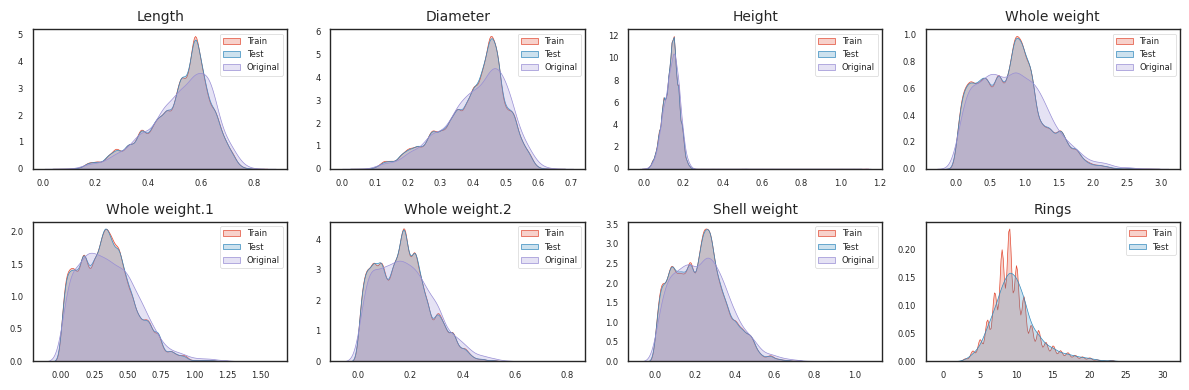

In [4]:
sns.set_style("white")
fig, axes = plt.subplots(2, 4, figsize=(12, 4))
for i, col in enumerate(numerical_features + ['Rings']):
    sns.kdeplot(data=train, x=col, ax=axes[i // 4, i % 4], fill=True)
    if col != 'Rings':
        sns.kdeplot(data=test, x=col, ax=axes[i // 4, i % 4], fill=True)
    sns.kdeplot(data=original, x=col, ax=axes[i // 4, i % 4], fill=True)
    axes[i // 4, i % 4].set_title(col, fontsize=10)
    axes[i // 4, i % 4].set_xlabel('')
    axes[i // 4, i % 4].set_ylabel('')
    axes[i // 4, i % 4].tick_params(axis='both', which='major', labelsize=6)
    axes[i // 4, i % 4].legend(['Train', 'Test', 'Original'], loc='best', fontsize=6)
    
plt.tight_layout()
plt.show()

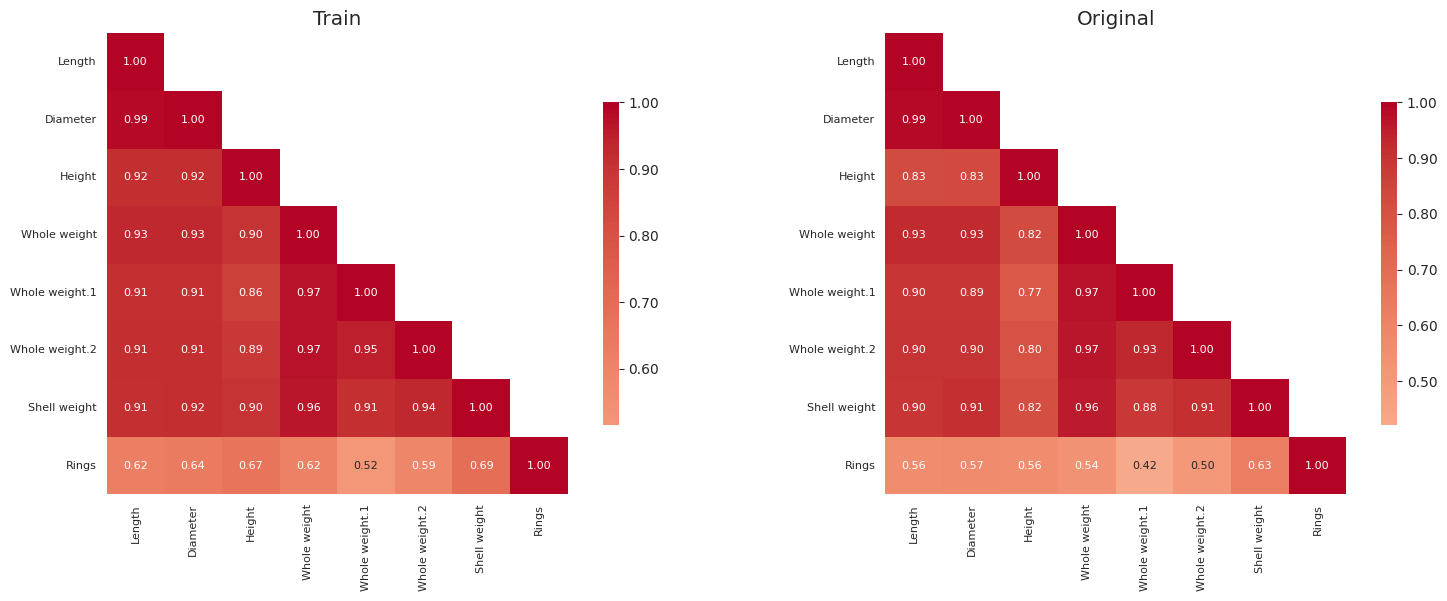

In [5]:
sns.set_style("white")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

corr_train = train[numerical_features + ['Rings']].corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)
sns.heatmap(
    data=corr_train,
    annot=True,
    fmt='.2f',
    mask=mask_train,
    square=True,
    cmap='coolwarm',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={'size': 8},
    center=0,
    ax=axes[0]
)
axes[0].set_title('Train')
axes[0].tick_params(axis='both', which='major', labelsize=8)

corr_orig = original[numerical_features + ['Rings']].corr()
mask_orig = np.triu(np.ones_like(corr_orig, dtype=bool), k=1)
sns.heatmap(
    data=corr_orig,
    annot=True,
    fmt='.2f',
    mask=mask_orig,
    square=True,
    cmap='coolwarm',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={'size': 8},
    center=0,
    ax=axes[1]
)
axes[1].set_title('Original')
axes[1].tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()

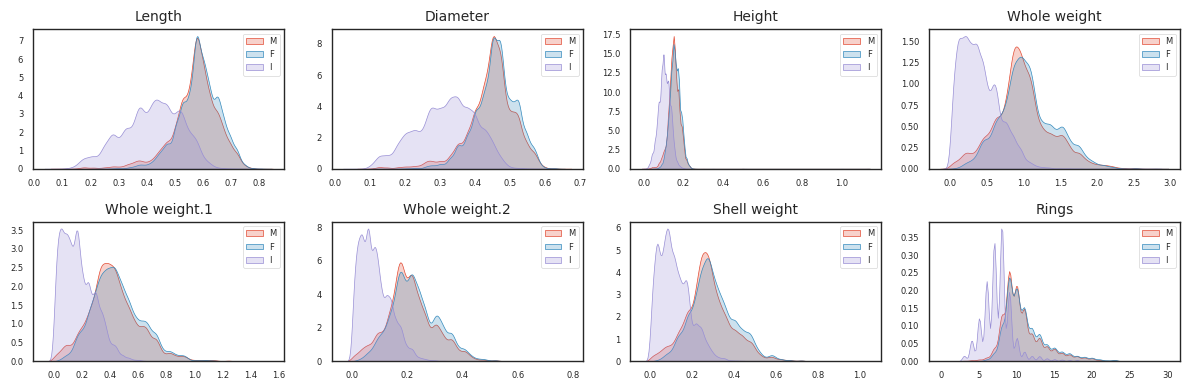

In [6]:
sns.set_style("white")
fig, axes = plt.subplots(2, 4, figsize=(12, 4))
for i, col in enumerate(numerical_features + ['Rings']):
    sns.kdeplot(data=train[train['Sex'] == 0], x=col, ax=axes[i // 4, i % 4], fill=True)
    sns.kdeplot(data=train[train['Sex'] == 1], x=col, ax=axes[i // 4, i % 4], fill=True)
    sns.kdeplot(data=train[train['Sex'] == 2], x=col, ax=axes[i // 4, i % 4], fill=True)
    axes[i // 4, i % 4].set_title(col, fontsize=10)
    axes[i // 4, i % 4].set_xlabel('')
    axes[i // 4, i % 4].set_ylabel('')
    axes[i // 4, i % 4].tick_params(axis='both', which='major', labelsize=6)
    axes[i // 4, i % 4].legend(['M', 'F', 'I'], loc='best', fontsize=6)
    
plt.tight_layout()
plt.show()

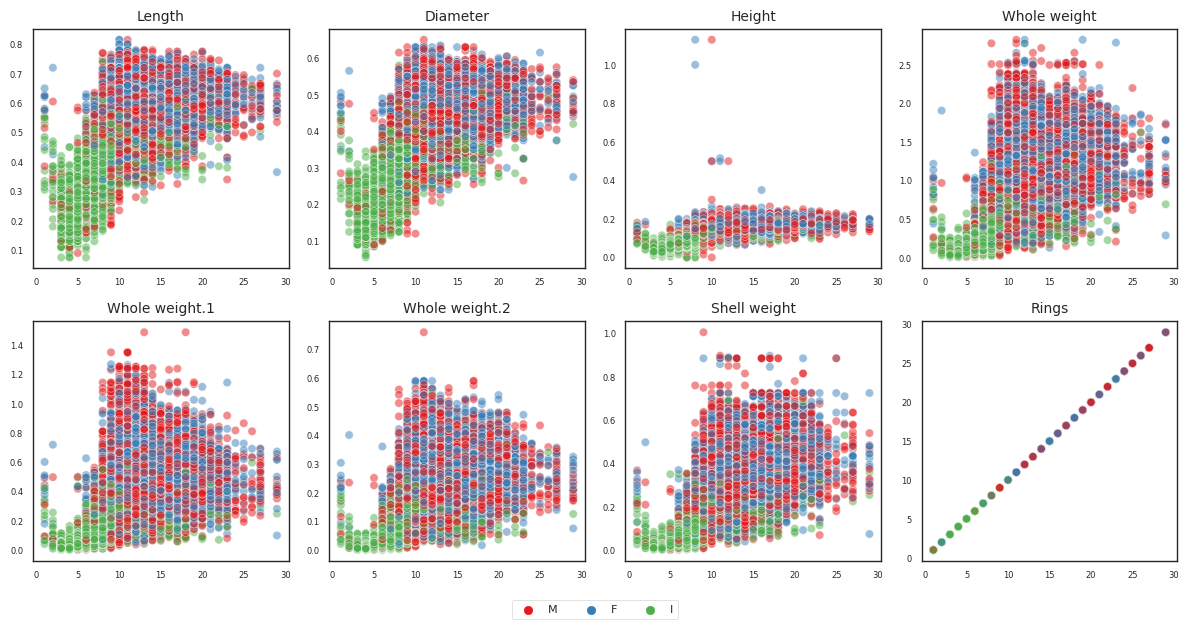

In [7]:
sns.set_style("white")
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, col in enumerate(numerical_features + ['Rings']):
    scatter = sns.scatterplot(data=train, x=train['Rings'], y=train[col], hue='Sex', ax=axes[i // 4, i % 4], alpha=0.5, palette='Set1')
    axes[i // 4, i % 4].set_title(col, fontsize=10)
    axes[i // 4, i % 4].set_xlabel('')
    axes[i // 4, i % 4].set_ylabel('')
    axes[i // 4, i % 4].tick_params(axis='both', which='major', labelsize=6)
    axes[i // 4, i % 4].get_legend().remove()

handles, labels = scatter.get_legend_handles_labels()
fig.legend(handles=handles, labels=['M', 'F', 'I'], loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05), fontsize=8)

plt.tight_layout()
plt.show()

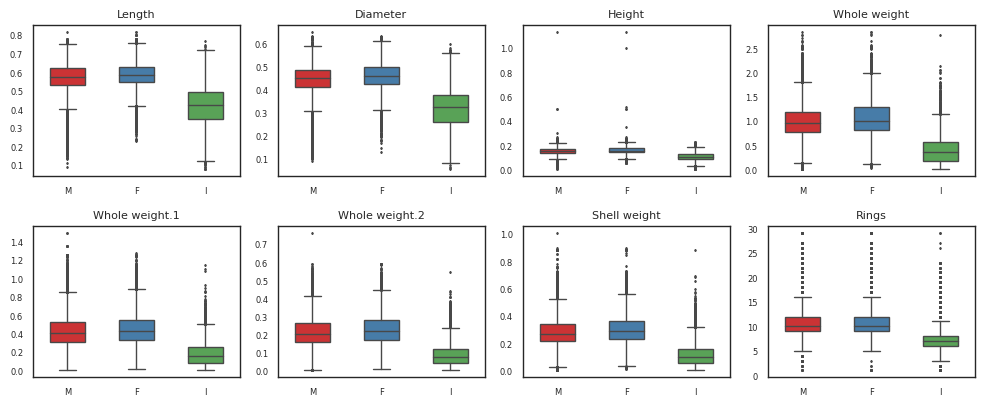

In [8]:
sns.set_style("white")
fig = plt.figure(figsize=[10, 8])
fig.subplots_adjust(top=0.92, hspace=0.5, wspace=0.4)

for i, col in enumerate(numerical_features + ['Rings']):
    ax = fig.add_subplot(4, 4, i+1)
    sns.boxplot(data=train, y=col, x='Sex', ax=ax, palette='Set1', linewidth=1, fliersize=1, width=0.5)
    ax.set_title(col, fontsize=8)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set_xticklabels(['M', 'F', 'I'])

plt.tight_layout()
plt.show()

# Training Base Models

In [9]:
def train(regressor, X, y, n_splits=N_SPLITS, n_repeats=N_REPEATS):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    model = TransformedTargetRegressor(
        regressor=regressor,
        func=np.log1p,
        inverse_func=np.expm1
    )
    
    oof_preds = np.zeros(len(X), dtype=float)
    scores = []
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        y_pred = np.zeros_like(y_val, dtype=float)
        for i in range(n_repeats):
            m = clone(model)
            if n_repeats > 1:
                m.regressor.set_params(random_state=i)
            m.fit(X_train, y_train)
            y_pred += m.predict(X_val)
            
        y_pred /= n_repeats
        y_pred = y_pred.clip(1, 29)
        
        score = mean_squared_log_error(y_val, y_pred, squared=False)
        scores.append(score)        
        oof_preds[val_idx] = y_pred
    
    return scores, oof_preds

def predict(regressor, X, y, X_test, n_repeats=N_REPEATS):
    model = TransformedTargetRegressor(
        regressor=regressor,
        func=np.log1p,
        inverse_func=np.expm1
    )
    
    y_pred = np.zeros(len(X_test), dtype=float)
    for i in range(n_repeats):
        m = clone(model)
        if n_repeats > 1:
            m.regressor.set_params(random_state=i)
        m.fit(X, y)
        y_pred += m.predict(X_test)
    y_pred /= n_repeats
    y_pred = y_pred.clip(1, 29)
    return y_pred

In [10]:
# def xgb_objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 1000, 4000),
#         'max_depth': trial.suggest_int('max_depth', 10, 25),
#         'max_leaves': trial.suggest_int('max_leaves', 10, 100),
#         'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.5),
#         'objective': trial.suggest_categorical('objective', ['reg:squarederror', 'reg:squaredlogerror', 'reg:gamma', 'reg:tweedie', 'reg:pseudohubererror']),
#         'gamma': trial.suggest_loguniform('gamma', 0.001, 0.5),
#         'min_child_weight': trial.suggest_loguniform('min_child_weight', 0.01, 10),
#         'max_delta_step': trial.suggest_loguniform('max_delta_step', 0.1, 10),
#         'subsample': trial.suggest_uniform('subsample', 0.01, 1),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.01, 1),
#         'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.01, 1),
#         'colsample_bynode': trial.suggest_uniform('colsample_bynode', 0.01, 1),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.01, 10),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.1, 10),
#         'random_state': SEED
#     }
    
#     regressor = XGBRegressor(**params)
#     scores, _ = train(regressor, X, y)
    
#     return np.mean(scores)

# xgb_study = optuna.create_study(direction='minimize')
# xgb_study.optimize(xgb_objective, n_trials=10000, catch=(ValueError,RuntimeError), n_jobs=-1)

# xgb_params = {
#     **xgb_study.best_params,
#     'random_state': SEED,
#     'n_jobs': -1,
# }

In [11]:
# def cb_objective(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 100, 2000),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.5),
#         'depth': trial.suggest_int('depth', 1, 16),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10),
#         'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),
#         'colsample_bylevel': trial.suggest_loguniform('colsample_bylevel', 0.05, 1),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
#         'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
#         'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
#         'random_state': SEED,
#         'verbose': False
#     }
    
#     regressor = CatBoostRegressor(**params)
#     scores, _ = train(regressor, X, y)

#     return np.mean(scores)

# cb_study = optuna.create_study(direction='minimize')
# cb_study.optimize(cb_objective, n_trials=1000, catch=(ValueError,RuntimeError), n_jobs=-1)

# cb_params = {
#     **cb_study.best_params,
#     'random_state': SEED,
#     'verbose': False
# }

In [12]:
# def lgbm_objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_depth': trial.suggest_int('max_depth', 1, 250),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.5),
#         'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 500),
#         'min_child_samples': trial.suggest_int('min_child_samples', 1, 200),
#         'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-9, 1.0),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-9, 1.0),
#         'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
#         'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-5, 1e5),      
#         'random_state': SEED,
#         'verbose': -1,
#         'n_jobs': -1
#     }
    
#     regressor = LGBMRegressor(**params)
#     scores, _ = train(regressor, X, y)

#     return np.mean(scores)

# lgbm_study = optuna.create_study(direction='minimize')
# lgbm_study.optimize(lgbm_objective, n_trials=10000, catch=(ValueError,RuntimeError), n_jobs=-1)

# lgbm_params = {
#     **lgbm_study.best_params,
#     'random_state': SEED,
#     'verbose': -1,
#     'n_jobs': -1
# }

In [13]:
# def dt_objective(trial):
#     params = {
#         'criterion': trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
#         'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
#         'max_depth': trial.suggest_int('max_depth', 1, 50),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
#         'min_weight_fraction_leaf': trial.suggest_uniform('min_weight_fraction_leaf', 0.0, 0.5),
#         'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 50),
#         'min_impurity_decrease': trial.suggest_uniform('min_impurity_decrease', 0.0, 0.5),
#         'ccp_alpha': trial.suggest_uniform('ccp_alpha', 0.0, 0.5),        
#         'random_state': SEED
#     }
    
#     regressor = DecisionTreeRegressor(**params)
#     scores, _ = train(regressor, X, y)

#     return np.mean(scores)

# dt_study = optuna.create_study(direction='minimize')
# dt_study.optimize(dt_objective, n_trials=10000, catch=(ValueError,RuntimeError), n_jobs=-1)

# dt_params = {
#     **dt_study.best_params,
#     'random_state': SEED
# }

In [14]:
# def et_objective(trial):
#     params = {
#         'criterion': trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
#         'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
#         'max_depth': trial.suggest_int('max_depth', 1, 50),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
#         'min_weight_fraction_leaf': trial.suggest_uniform('min_weight_fraction_leaf', 0.0, 0.5),
#         'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 200),
#         'min_impurity_decrease': trial.suggest_uniform('min_impurity_decrease', 0.0, 0.5),
#         'ccp_alpha': trial.suggest_uniform('ccp_alpha', 0.0, 0.5),        
#         'random_state': SEED
#     }
    
#     regressor = ExtraTreeRegressor(**params)
#     scores, _ = train(regressor, X, y)

#     return np.mean(scores)

# et_study = optuna.create_study(direction='minimize')
# et_study.optimize(et_objective, n_trials=10000, catch=(ValueError,RuntimeError), n_jobs=-1)

# et_params = {
#     **et_study.best_params,
#     'random_state': SEED
# }

In [15]:
xgb_params = {
    'n_jobs': -1,
    'max_depth': 6,
    'n_estimators': 1942,
    'random_state': SEED,
    'min_child_weight': 1,
    'gamma': 0.03564293452391207,
    'subsample': 0.6956271823055759,
    'reg_alpha': 0.7236848478280202,
    'reg_lambda': 0.6760094001242347,
    'learning_rate': 0.04328457758575266,
    'colsample_bynode': 0.962341555268564,
    'colsample_bytree': 0.7506537997746077,
    'colsample_bylevel': 0.8727635788126956,
}

cb_params = {
    'depth': 15, 
    'verbose': 0,
    'max_bin': 464, 
    'verbose': False,
    'task_type': 'CPU', 
    'random_state':SEED,
    'eval_metric': 'RMSE', 
    'min_data_in_leaf': 78, 
    'loss_function': 'RMSE', 
    'grow_policy': 'Lossguide', 
    'bootstrap_type': 'Bernoulli', 
    'subsample': 0.83862137638162, 
    'l2_leaf_reg': 8.365422739510098, 
    'random_strength': 3.296124856352495, 
    'learning_rate': 0.09992185242598203,
}

lgbm_params = {
    'n_jobs': -1,
    'verbose': -1,
    'max_depth': 20,
    'num_leaves': 165,
    'subsample_freq': 1,
    'random_state': SEED,
    'n_estimators': 1460,
    'min_child_samples': 25,
    'reg_lambda': 6.13475387151606,
    'subsample': 0.8036874216939632,
    'reg_alpha': 0.3152990674231573,
    'learning_rate': 0.009336479469693189,
    'colsample_bytree': 0.5780931837049811,
    'min_child_weight': 0.37333232256934057,
}

dt_params = {
    'max_depth': 49, 
    'splitter': 'best',
    'max_leaf_nodes': 42, 
    'random_state': SEED,
    'min_samples_leaf': 9,
    'min_samples_split': 13, 
    'criterion': 'friedman_mse', 
    'ccp_alpha': 2.4228973284677285e-05,
    'min_impurity_decrease': 0.009765739864102028, 
    'min_weight_fraction_leaf': 0.0010563215439212178, 
}

et_params = {
    'max_depth': 25,
    'splitter': 'random',
    'random_state': SEED,
    'max_leaf_nodes': 146, 
    'min_samples_leaf': 30, 
    'min_samples_split': 26,
    'criterion': 'friedman_mse',
    'ccp_alpha': 2.5726185042055587e-06,
    'min_impurity_decrease': 0.08535937657207235, 
    'min_weight_fraction_leaf': 0.0002510333976148155,
}

In [16]:
xgb_model = XGBRegressor(**xgb_params)
xgb_scores, xgb_oof_preds = train(xgb_model, X, y)
print(f'XGB:    {np.mean(xgb_scores)}')

cb_model = CatBoostRegressor(**cb_params)
cb_scores, cb_oof_preds = train(cb_model, X, y)
print(f'CB:     {np.mean(cb_scores)}')

lgbm_model = LGBMRegressor(**lgbm_params)
lgbm_scores, lgbm_oof_preds = train(lgbm_model, X, y)
print(f'LGBM:   {np.mean(lgbm_scores)}')

dt_model = DecisionTreeRegressor(**dt_params)
dt_scores, dt_oof_preds = train(dt_model, X, y)
print(f'DT:     {np.mean(dt_scores)}')

et_model = ExtraTreeRegressor(**et_params)
et_scores, et_oof_preds = train(et_model, X, y)
print(f'ET:     {np.mean(et_scores)}')

XGB:    0.14828680025204577
CB:     0.1475879632917944
LGBM:   0.1477611444102072
DT:     0.1588657117812041
ET:     0.15625635008020103


# Ensembling Base Learners

In [17]:
estimators = [
    ('xgb', xgb_model),
    ('cb', cb_model),
    ('lgbm', lgbm_model),
    ('dt', dt_model),
    ('et', et_model),
]

In [18]:
# def voter_objective(trial):
#     params = {
#         'xgb_weight': trial.suggest_float('xgb_weight', 0.0, 1.0),
#         'cb_weight': trial.suggest_float('cb_weight', 0.0, 1.0),
#         'lgbm_weight': trial.suggest_float('lgbm_weight', 0.0, 1.0),
#         'dt_weight': trial.suggest_float('dt_weight', 0.0, 1.0),
#         'et_weight': trial.suggest_float('et_weight', 0.0, 1.0),
#     }

#     weights = [
#         params['xgb_weight'],
#         params['cb_weight'],
#         params['lgbm_weight'],
#         params['dt_weight'],
#         params['et_weight']
#     ]
#     weights /= np.sum(weights)

#     voter = VotingRegressor(estimators=estimators, weights=weights)
#     scores, _ = train(voter, X, y, 10, 1)
    
#     return np.mean(scores)

# study = optuna.create_study(direction='minimize')
# study.optimize(voter_objective, n_trials=10000, catch=(ValueError,RuntimeError), n_jobs=-1)

# best_weights = study.best_params
best_weights = {
    'xgb_weight': 0.29897445535779177, 
    'cb_weight': 0.515494651856609, 
    'lgbm_weight': 0.7293568934424759, 
    'dt_weight': 0.060915255332017616, 
    'et_weight': 0.0023339048671300877
}

weights = [
    best_weights['xgb_weight'],
    best_weights['cb_weight'],
    best_weights['lgbm_weight'],
    best_weights['dt_weight'],
    best_weights['et_weight']
]

weights /= np.sum(weights)

In [19]:
voter = VotingRegressor(estimators=estimators, weights=weights, n_jobs=-1)
voter_scores, oof_preds = train(voter, X, y, N_SPLITS, 1)

print(f'Ensemble: {np.mean(voter_scores)}')

Ensemble: 0.14751035752091168


# Results

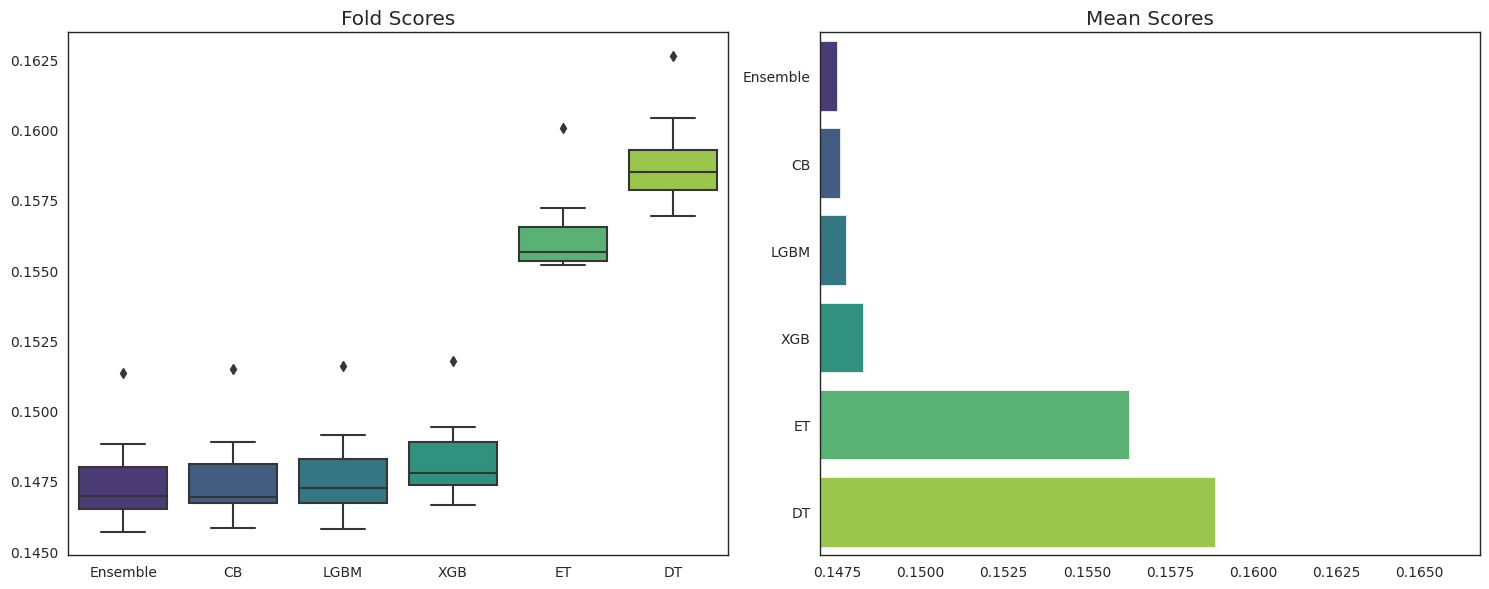

In [20]:
scores = pd.DataFrame({
    'XGB': xgb_scores,
    'CB': cb_scores,
    'LGBM': lgbm_scores,
    'DT': dt_scores,
    'ET': et_scores,
    'Ensemble': voter_scores
})
scores = scores[scores.mean().sort_values().index]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.boxplot(data=scores, ax=axes[0], palette='viridis')
axes[0].set_title('Fold Scores')
axes[0].set_xlabel('')
axes[0].set_ylabel('')
mean_scores = scores.mean().sort_values()
sns.barplot(x=mean_scores, y=mean_scores.index, orient='h', ax=axes[1], palette='viridis')
axes[1].set_title('Mean Scores')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_xlim(left=0.147)
plt.tight_layout()
plt.show()

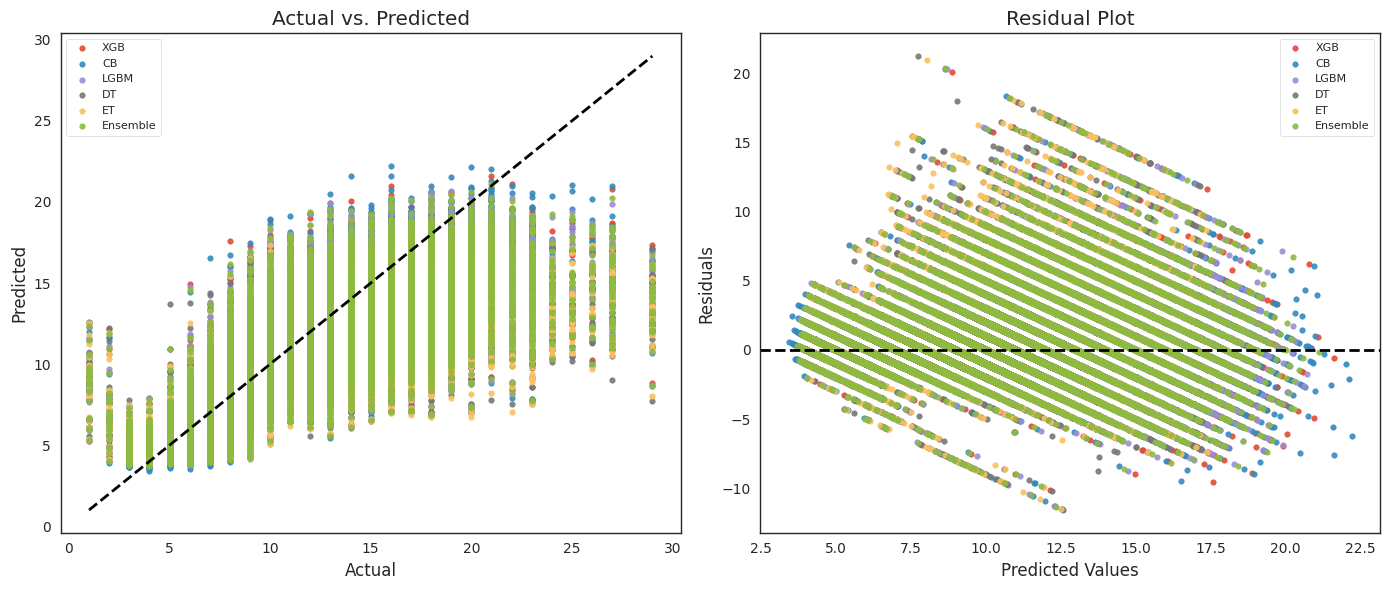

In [21]:
all_oof_preds = {
    'XGB': xgb_oof_preds,
    'CB': cb_oof_preds,
    'LGBM': lgbm_oof_preds,
    'DT': dt_oof_preds,
    'ET': et_oof_preds,
    'Ensemble': oof_preds
}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for model_name, model_oof_preds in all_oof_preds.items():
    axes[0].scatter(y, model_oof_preds, alpha=0.9, s=15, label=model_name)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title('Actual vs. Predicted')
axes[0].legend(loc='best', fontsize=8)

for model_name, model_oof_preds in all_oof_preds.items():
    axes[1].scatter(model_oof_preds, y - model_oof_preds, alpha=0.9, s=15, label=model_name)
axes[1].axhline(y=0, color='black', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')
axes[1].legend(loc='best', fontsize=8)

plt.tight_layout()
plt.show()

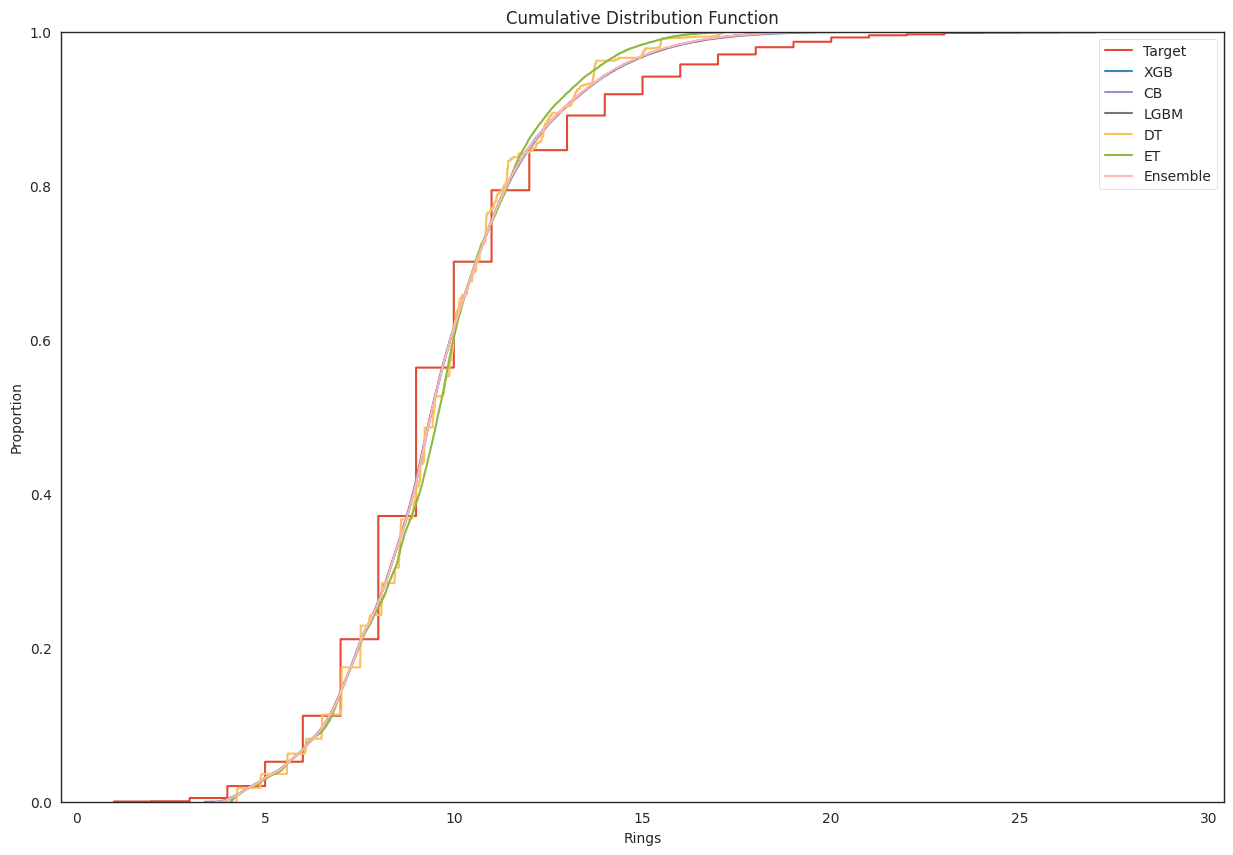

In [22]:
sns.set_style("white")
fig = plt.figure(figsize=[15, 10])

sns.ecdfplot(data=y, stat='proportion', complementary=False, label='Target')
for model_name, model_oof_preds in all_oof_preds.items():    
    sns.ecdfplot(data=model_oof_preds, stat='proportion', complementary=False, label=model_name)

plt.title('Cumulative Distribution Function', fontsize=12)
plt.xlabel('Rings', fontsize=10)
plt.ylabel('Proportion', fontsize=10)
plt.legend()
plt.show()

# Creating Submission

In [23]:
y_pred = predict(voter, X, y, test, 1)
voter_sub = pd.DataFrame({'id': test.index, 'Rings': y_pred})
voter_sub.to_csv(f'ensemble.csv', index=False)
voter_sub.head()

,id,Rings
0,90615,9.762379
1,90616,9.756342
2,90617,9.846804
3,90618,10.360785
4,90619,7.593703
